In [69]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from importlib import reload
import loss
import data_generator
import model
import train
import visualize
reload(loss)
reload(visualize)
reload(model)
reload(data_generator)
reload(train)

from data_generator import make_dataloaders
from model import MainModel
from train import train_model, load_model, build_backbone_unet, pretrain_generator
from background_detection import load_processed_images

In [70]:
BATCH_SIZE = 5
EPOCHS = 150
TRAIN_SET_SIZE = 0.8
COLOR_SPACE = 'Lab' # Lab or HSL or YCbCr
BACKBONE = 'resnet34' #backbones: resnet18, resnet34, vgg16_bn
path = "./data/part1"
l1loss = "L1Loss" # SmoothL1Loss or L1Loss
ganloss = "lsgan" # vanilla or lsgan


model_path =   f"./models/model_pretrained_noBG_part1_{BACKBONE}_{COLOR_SPACE}_{l1loss}_{ganloss}.pt"
paths = load_processed_images('./background_scores/filtered_part1')
pretrained_model = f"{BACKBONE}-unet_noBG_{COLOR_SPACE}.pt"
np.random.seed(123)
total_paths = len(paths) - (len(paths) % BATCH_SIZE)
len_train_paths = int(total_paths * TRAIN_SET_SIZE)
paths_subset = np.random.choice(paths, total_paths, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(total_paths)
train_idxs = rand_idxs[:len_train_paths] # choosing the first 80% as training set
val_idxs = rand_idxs[len_train_paths:] # choosing last 20% as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

6380 1595


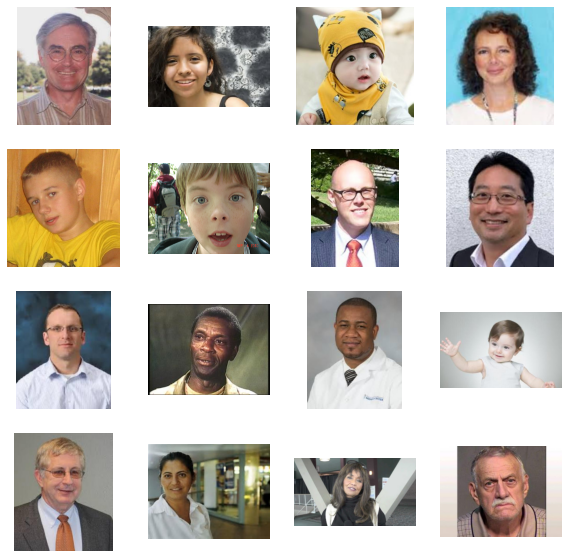

In [71]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [72]:
train_dl = make_dataloaders(batch_size=BATCH_SIZE, paths=train_paths, split='train', color_space=COLOR_SPACE)
val_dl = make_dataloaders(batch_size=BATCH_SIZE, paths=val_paths, split='val', color_space=COLOR_SPACE)

data = next(iter(train_dl))
known_channels, unknown_channels_ = data['known_channel'], data['unknown_channels']
print(known_channels.shape, unknown_channels_.shape)
print(len(train_dl), len(val_dl))

c:\users\s182125\pycharmprojects\cuda_test\venv\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([5, 1, 256, 256]) torch.Size([5, 2, 256, 256])
1276 319


In [73]:
# net_G = build_backbone_unet(n_input=1, n_output=2, size=256, backbone_name=BACKBONE)
# opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
# criterion = torch.nn.L1Loss()        
# pretrain_generator(net_G, train_dl, opt, criterion, 20, device=device)


In [74]:
# torch.save(net_G.state_dict(), pretrained_model)

In [75]:
net_G = build_backbone_unet(n_input=1, n_output=2, size=256, backbone_name=BACKBONE)
net_G.load_state_dict(torch.load(pretrained_model, map_location=device))

<All keys matched successfully>

In [76]:
loaded_model = MainModel(net_G=net_G, L1LossType=l1loss, ganloss=ganloss)
# # _, loss_meter_dict = load_model(model_path, loaded_model) # for model loaded from file

model initialized with norm initialization



Epoch 1/150
Iteration 288/1276


 22%|##2       | 287/1276 [03:25<10:01,  1.65it/s]

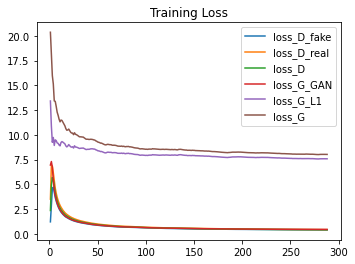

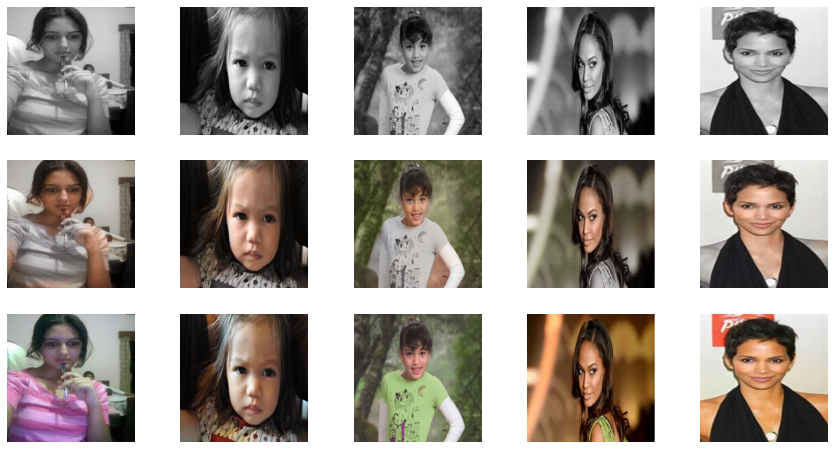

In [ ]:
#  train_model(loaded_model, train_dl, val_dl, COLOR_SPACE, 150, 10, loss_meter_dict=loss_meter_dict, save_path=model_path) # for model loaded from file
train_model(loaded_model, train_dl, val_dl, COLOR_SPACE, EPOCHS, 8, save_path=model_path) # for model trained from the begining


In [ ]:
from visualize import visualize

loaded_model = MainModel(net_G=net_G)
model, loss_meter_dict, train_loss_meter_dict = load_model(model_path, loaded_model)
for i, data in enumerate(iter(val_dl)):
    visualize(loaded_model, data, COLOR_SPACE, save=False)
    if i == 4:
        break